**Установка необходимы библиотек для Main.py**

In [ ]:
# Импорт библиотек
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import sklearn  # Импортируем sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt  # Импортируем matplotlib.pyplot как plt
from google.colab import files
import os

# Проверка версий библиотек (для requirements.txt)
print("Версии установленных библиотек:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Torch: {torch.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

# Основная функция-заглушка
def main():
    print("Проект 'Интеллектуальный помощник формирования рациона питания' запущен!")

if __name__ == "__main__":
    main()

Версии установленных библиотек:
NumPy: 2.0.2
Pandas: 2.2.2
Torch: 2.6.0+cu124
Scikit-learn: 1.6.1
Matplotlib: 3.10.0
Проект 'Интеллектуальный помощник формирования рациона питания' запущен!


**Telegram-bot @BotFoodAI_Bot**

In [ ]:
!pip install python-telegram-bot==13.7

In [ ]:
# telegram_bot.py
# Модуль для Telegram-бота
# Автор: [Ваше ФИО]
# Тема ВКР: Разработка интеллектуального помощника формирования рациона питания

import torch
import pickle
import pandas as pd
import numpy as np
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, ConversationHandler
from telegram import ReplyKeyboardMarkup
from data_preprocessing import load_data, find_products
from utils import load_model, load_calorie_model, load_nutrient_model
from sklearn.neighbors import NearestNeighbors

INPUT, MORE, VITAMIN_INPUT, PREDICT_INPUT = range(4)

def start(update, context):
    update.message.reply_text(
        "Привет! Я помогу подобрать цель питания и продукты.\n"
        "Команды:\n"
        "/predict - Предсказать калории и цель\n"
        "/nutrients - Предсказать витамины и минералы\n"
        "/vitamin_search - Найти продукты по витаминам/минералам"
    )
    return INPUT

def predict(update, context):
    context.user_data['waiting_for_predict'] = True
    update.message.reply_text("Введи данные: белки, жиры, углеводы (через запятую, например: 50,30,40).")
    return PREDICT_INPUT

def predict_input(update, context):
    try:
        data = [float(x.strip()) for x in update.message.text.split(',')]
        if len(data) != 3:
            raise ValueError("Должно быть 3 числа")
        protein, fat, carbs = data
        cal_input = torch.tensor([[protein, fat, carbs]], dtype=torch.float32)
        model = load_calorie_model()
        scaler = pickle.load(open('scaler.pkl', 'rb'))
        df = load_data('food.csv')

        with torch.no_grad():
            total_calories = model(cal_input).item()
        total_calories = max(100, min(total_calories, 2000))
        input_data = np.array([[total_calories, protein, fat, carbs]])
        features = scaler.transform(input_data)
        features = torch.tensor(features, dtype=torch.float32)
        model = load_model()
        with torch.no_grad():
            output = model(features)
            _, predicted = torch.max(output, 1)
        goals = {0: 'Похудение', 1: 'Набор массы', 2: 'Поддержание'}
        goal = goals[predicted.item()]

        top_products = find_products(df, total_calories, top_n=5)
        response = (
            f"Калории (по модели): {total_calories:.1f} ккал\n"
            f"Рекомендация: {goal}\n\n"
            f"Топ-5 похожих продуктов:\n"
        )
        for idx, row in top_products.iterrows():
            response += f"- {row['Description'].title()}: {row['Calculated_Kilocalories']:.1f} ккал, Вит. С: {row['Data vitamins vitamin c']:.1f} мг, Кальций: {row['Data major minerals calcium']:.1f} мг\n"

        reply_keyboard = [['Да', 'Нет']]
        markup = ReplyKeyboardMarkup(reply_keyboard, one_time_keyboard=True)
        update.message.reply_text(response + "\nХотите больше продуктов?", reply_markup=markup)
        context.user_data['total_calories'] = total_calories
        context.user_data['input'] = [protein, fat, carbs]
        context.user_data['waiting_for_predict'] = False
        return MORE
    except Exception as e:
        update.message.reply_text(f"Ошибка: {str(e)}. Введи 3 числа через запятую (например: 50,30,40).")
        return PREDICT_INPUT

def nutrients(update, context):
    try:
        if 'input' not in context.user_data:
            update.message.reply_text("Сначала используй /predict, чтобы ввести белки, жиры, углеводы!")
            return INPUT
        protein, fat, carbs = context.user_data['input']
        input_data = torch.tensor([[protein, fat, carbs]], dtype=torch.float32)
        model = load_nutrient_model()
        with torch.no_grad():
            output = model(input_data)
            vitamin_c, calcium, vitamin_b12, iron = output[0].tolist()
        response = (
            f"Прогноз питательных веществ:\n"
            f"Витамин С: {vitamin_c:.1f} мг\n"
            f"Кальций: {calcium:.1f} мг\n"
            f"Витамин B12: {vitamin_b12:.2f} мкг\n"
            f"Железо: {iron:.1f} мг"
        )
        update.message.reply_text(response)
        return INPUT
    except Exception as e:
        update.message.reply_text(f"Ошибка: {str(e)}. Попробуй снова.")
        return INPUT

def vitamin_search(update, context):
    context.user_data['waiting_for_vitamin'] = True
    update.message.reply_text(
        "Выбери витамины/минералы для поиска (через запятую, например: vitamin_c,calcium или all).\n"
        "Доступные: vitamin_c, calcium, b12, iron, all.\n"
        "Затем введи значения (например: 90,1000 для vitamin_c,calcium или 'default' для норм)."
    )
    return VITAMIN_INPUT

def vitamin_search_input(update, context):
    if not context.user_data.get('waiting_for_vitamin', False):
        update.message.reply_text("Сначала используй /vitamin_search!")
        return INPUT
    try:
        df = load_data('food.csv')
        all_columns = ['Data vitamins vitamin c', 'Data major minerals calcium', 'Data vitamins vitamin b12', 'Data major minerals iron']
        user_input = update.message.text.lower().split(';')
        if len(user_input) != 2:
            raise ValueError("Введи: витамины/минералы;значения (например: vitamin_c,calcium;90,1000 или all;default)")

        selected_nutrients = user_input[0].split(',')
        if 'all' in selected_nutrients:
            selected_columns = all_columns
            nutrient_names = ['vitamin_c', 'calcium', 'b12', 'iron']
        else:
            nutrient_map = {
                'vitamin_c': 'Data vitamins vitamin c',
                'calcium': 'Data major minerals calcium',
                'b12': 'Data vitamins vitamin b12',
                'iron': 'Data major minerals iron'
            }
            selected_columns = [nutrient_map[nutrient] for nutrient in selected_nutrients if nutrient in nutrient_map]
            nutrient_names = [nutrient for nutrient in selected_nutrients if nutrient in nutrient_map]
            if not selected_columns:
                raise ValueError("Неверные названия витаминов/минералов")

        if not all(col in df.columns for col in selected_columns):
            update.message.reply_text(f"Ошибка: отсутствуют столбцы {selected_columns}")
            return INPUT

        values = user_input[1]
        if values == 'default':
            default_values = {'vitamin_c': 90, 'calcium': 1000, 'b12': 2.4, 'iron': 8}
            input_features = np.array([[default_values[n] for n in nutrient_names]])
        else:
            data = [float(x.strip()) for x in values.split(',')]
            if len(data) != len(selected_columns):
                raise ValueError(f"Должно быть {len(selected_columns)} числа")
            input_features = np.array([data])

        features = df[selected_columns].values
        nn = NearestNeighbors(n_neighbors=20, algorithm='auto')
        nn.fit(features)
        distances, indices = nn.kneighbors(input_features)
        top_products = df.iloc[indices[0]][['Description'] + selected_columns]

        response = "Продукты с высоким содержанием выбранных витаминов/минералов:\n"
        for idx, row in top_products.head(10).iterrows():
            response += f"- {row['Description'].title()}: "
            for col, name in zip(selected_columns, nutrient_names):
                response += f"{name} {row[col]:.1f} {'мг' if name != 'b12' else 'мкг'}, "
            response = response.rstrip(', ') + "\n"

        excel_file = 'vitamin_products.xlsx'
        top_products.to_excel(excel_file, index=False)
        with open(excel_file, 'rb') as f:
            update.message.reply_document(
                document=f,
                filename=excel_file,
                caption="Полный список продуктов в Excel!"
            )

        update.message.reply_text(response)
        context.user_data['waiting_for_vitamin'] = False
        return INPUT
    except Exception as e:
        update.message.reply_text(f"Ошибка: {str(e)}. Введи: витамины/минералы;значения (например: vitamin_c,calcium;90,1000 или all;default).")
        return VITAMIN_INPUT

def more_products(update, context):
    response = update.message.text.lower()
    if response == 'да':
        total_calories = context.user_data['total_calories']
        df = load_data('food.csv')
        more_products = find_products(df, total_calories, top_n=100)
        excel_file = 'top_100_products.xlsx'
        more_products.to_excel(excel_file, index=False)
        with open(excel_file, 'rb') as f:
            update.message.reply_document(
                document=f,
                filename=excel_file,
                caption="Вот список топ-100 продуктов!"
            )
    reply_keyboard = [['Старт']]
    markup = ReplyKeyboardMarkup(reply_keyboard, one_time_keyboard=True)
    update.message.reply_text("Что дальше?", reply_markup=markup)
    return INPUT

def main():
    updater = Updater("7543999760:AAEeB8PJRE41LUPn-V3WCFscMcL7lwMXGqw", use_context=True)
    conv_handler = ConversationHandler(
        entry_points=[CommandHandler('start', start), CommandHandler('predict', predict), CommandHandler('vitamin_search', vitamin_search)],
        states={
            INPUT: [CommandHandler('nutrients', nutrients), CommandHandler('vitamin_search', vitamin_search), CommandHandler('predict', predict)],
            PREDICT_INPUT: [MessageHandler(Filters.text & ~Filters.command, predict_input)],
            MORE: [MessageHandler(Filters.text & ~Filters.command, more_products)],
            VITAMIN_INPUT: [MessageHandler(Filters.text & ~Filters.command, vitamin_search_input)]
        },
        fallbacks=[CommandHandler('start', start)]
    )
    updater.dispatcher.add_handler(conv_handler)
    updater.start_polling()
    updater.idle()

if __name__ == "__main__":
    main()

**Ядро проекта Main.py конечный вариант**

Проект 'Интеллектуальный помощник формирования рациона питания' запущен!
Доступно GPU: False


Downloading...
From: https://drive.google.com/uc?id=1aHKaB8cjZPSk7gS-VPzk3ppKV8-AO0d7
To: /content/food.csv
100%|██████████| 1.53M/1.53M [00:00<00:00, 130MB/s]


Датасет загружен в food.csv
Попытка загрузки файла: food.csv
Успешная загрузка: 7083 строк, 38 столбцов
Первые 5 строк:
  Cate category                   Description  Nutrient data bank number  \
0          Milk                    Milk human                   11000000   
1          Milk                      Milk NFS                   11100000   
2          Milk                    Milk whole                   11111000   
3          Milk         Milk low sodium whole                   11111100   
4          Milk  Milk calcium fortified whole                   11111150   

   Data alpha carotene  Data beta carotene  Data beta cryptoxanthin  \
0                    0                   7                        0   
1                    0                   4                        0   
2                    0                   7                        0   
3                    0                   7                        0   
4                    0                   7                        0 

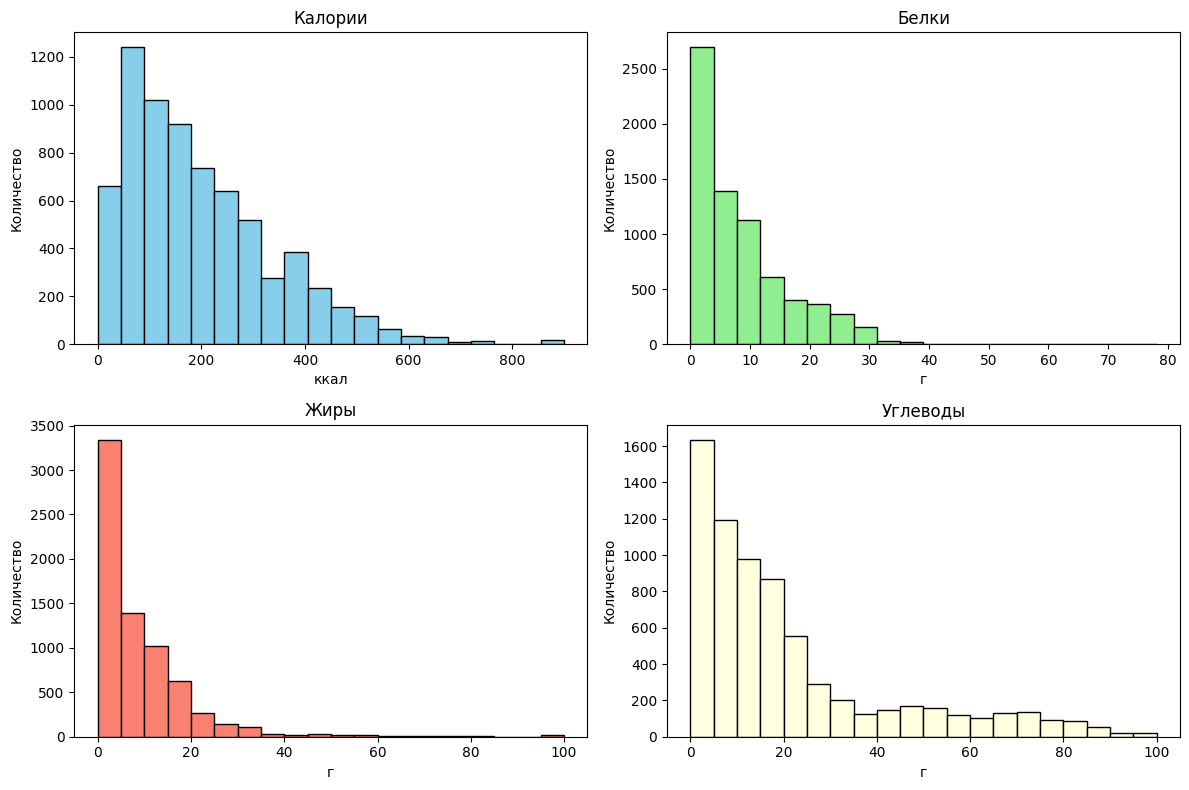

Визуализация данных завершена
Данные подготовлены:
X_train: torch.Size([244, 4]), y_train: torch.Size([244])
X_test: torch.Size([62, 4]), y_test: torch.Size([62])
Модель целей создана: DietAssistantModel(
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (layer4): Linear(in_features=16, out_features=3, bias=True)
)
Обучение модели целей...
Обучение на устройстве: cpu
Epoch 0, Loss: 0.8691
Epoch 10, Loss: 0.1468
Epoch 20, Loss: 0.1150
Epoch 30, Loss: 0.0701
Epoch 40, Loss: 0.0888
Epoch 50, Loss: 0.1035
Epoch 60, Loss: 0.0535
Epoch 70, Loss: 0.0532
Epoch 80, Loss: 0.0472
Epoch 90, Loss: 0.0318


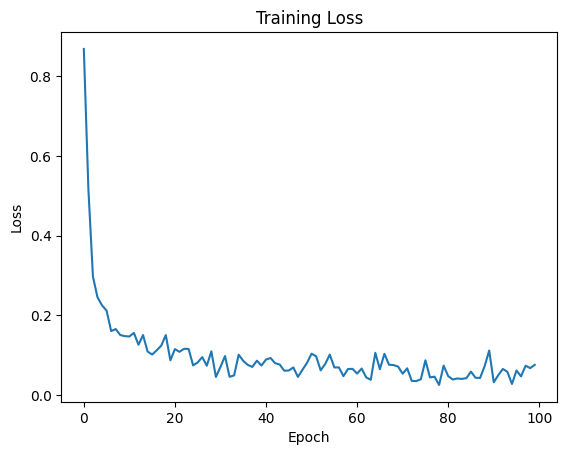

Обучение завершено за 3.03 секунд
Тестирование модели целей...
Accuracy: 95.16%
Precision (weighted): 0.9524
Recall (weighted): 0.9516
F1-score (weighted): 0.9516
Метрики по классам (weight_loss, muscle_gain, maintenance):
Precision: [0.95238095 1.         0.9047619 ]
Recall: [0.90909091 1.         0.95      ]
F1-score: [0.93023256 1.         0.92682927]
Тестирование завершено за 0.01 секунд
Обучение модели калорий...
Calorie Model Epoch 0, Loss: 237138.3158
Calorie Model Epoch 100, Loss: 6185.0466
Calorie Model Epoch 200, Loss: 4577.1917
Calorie Model Epoch 300, Loss: 4049.5621
Calorie Model Epoch 400, Loss: 3866.5106
Calorie Model Epoch 500, Loss: 3779.4945
Calorie Model Epoch 600, Loss: 3757.7858
Calorie Model Epoch 700, Loss: 3783.3983
Calorie Model Epoch 800, Loss: 3521.1140
Calorie Model Epoch 900, Loss: 3596.0076
Calorie Model Epoch 1000, Loss: 3637.7935
Calorie Model Epoch 1100, Loss: 3364.5279
Calorie Model Epoch 1200, Loss: 3568.1926
Calorie Model Epoch 1300, Loss: 3417.1025


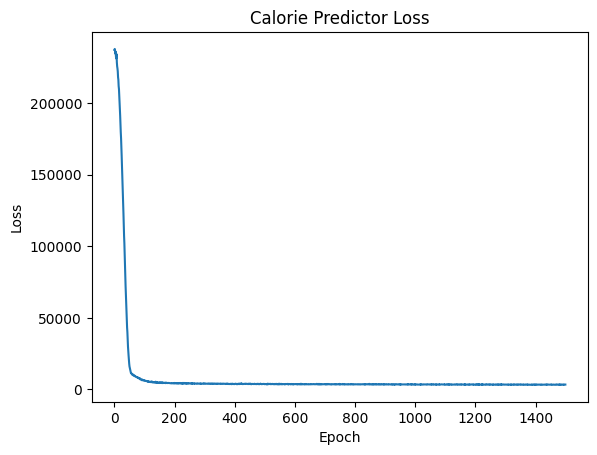

Test Loss: 43.5164
Обучение модели витаминов и минералов...
Nutrient Model Epoch 0, Loss: 4869.2411
Nutrient Model Epoch 100, Loss: 3417.5723
Nutrient Model Epoch 200, Loss: 3279.8869
Nutrient Model Epoch 300, Loss: 3211.2757
Nutrient Model Epoch 400, Loss: 3179.5631
Nutrient Model Epoch 500, Loss: 3129.2429
Nutrient Model Epoch 600, Loss: 3086.2121
Nutrient Model Epoch 700, Loss: 3038.9265
Nutrient Model Epoch 800, Loss: 3008.2831
Nutrient Model Epoch 900, Loss: 2982.8197
Nutrient Model Epoch 1000, Loss: 3015.2089
Nutrient Model Epoch 1100, Loss: 2895.0469
Nutrient Model Epoch 1200, Loss: 2935.0287
Nutrient Model Epoch 1300, Loss: 2942.8883
Nutrient Model Epoch 1400, Loss: 2929.7791


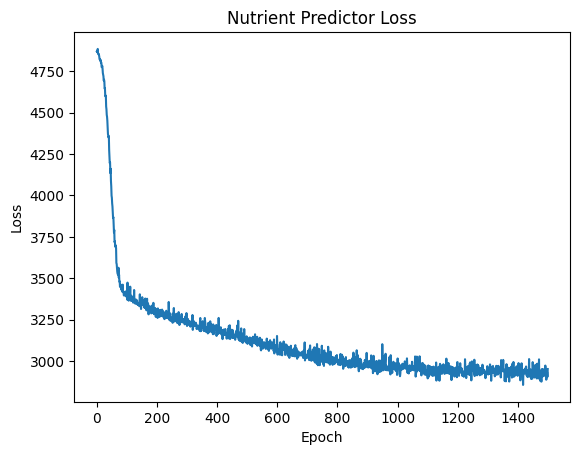

Test Loss: 2467.2075
Модель сохранена в model.pt
Scaler сохранён в scaler.pkl
Модель калорий сохранена в calorie_model.pt
Модель витаминов сохранена в nutrient_model.pt


In [ ]:
# main.py
# Основной файл для запуска интеллектуального помощника
# Автор: [Ваше ФИО]
# Тема ВКР: Разработка интеллектуального помощника формирования рациона питания

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import os
import time
from torch.utils.data import DataLoader, TensorDataset
import pickle
from data_preprocessing import download_dataset, load_data, preprocess_data, clean_data
from model import DietAssistantModel, CaloriePredictor, NutrientPredictor
from train import train_model, evaluate_model
from visualize import visualize_data
from utils import save_model_and_scaler, load_model, load_calorie_model, load_nutrient_model

def train_calorie_model(df, epochs=1500, lr=0.00001):
    """Обучение модели предсказания калорий."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CaloriePredictor(input_size=3).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    required_columns = ['Data protein', 'Data fat total lipid', 'Data carbohydrate']
    if not all(col in df.columns for col in required_columns):
        print(f"Ошибка: отсутствуют необходимые столбцы {required_columns}")
        return None

    features = df[['Data protein', 'Data fat total lipid', 'Data carbohydrate']].values
    targets = 4 * features[:, 0] + 9 * features[:, 1] + 4 * features[:, 2]

    synth_protein = np.random.uniform(0, 100, 5000)
    synth_fat = np.random.uniform(0, 60, 5000)
    synth_carbs = np.random.uniform(0, 100, 5000)
    synth_calories = 4 * synth_protein + 9 * synth_fat + 4 * synth_carbs
    synth_features = np.vstack([synth_protein, synth_fat, synth_carbs]).T
    synth_targets = synth_calories

    features = np.vstack([features, synth_features])
    targets = np.concatenate([targets, synth_targets])

    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        if epoch % 100 == 0:
            print(f"Calorie Model Epoch {epoch}, Loss: {avg_loss:.4f}")
    plt.plot(losses)
    plt.title("Calorie Predictor Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")
    return model

def train_nutrient_model(df, epochs=1500, lr=0.00001):
    """Обучение модели предсказания витаминов и минералов."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NutrientPredictor(input_size=3, output_size=4).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    required_columns = ['Data protein', 'Data fat total lipid', 'Data carbohydrate', 'Data vitamins vitamin c', 'Data major minerals calcium', 'Data vitamins vitamin b12', 'Data major minerals iron']
    if not all(col in df.columns for col in required_columns):
        print(f"Ошибка: отсутствуют необходимые столбцы {required_columns}")
        return None

    features = df[['Data protein', 'Data fat total lipid', 'Data carbohydrate']].values
    targets = df[['Data vitamins vitamin c', 'Data major minerals calcium', 'Data vitamins vitamin b12', 'Data major minerals iron']].values

    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        if epoch % 100 == 0:
            print(f"Nutrient Model Epoch {epoch}, Loss: {avg_loss:.4f}")
    plt.plot(losses)
    plt.title("Nutrient Predictor Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
    print(f"Test Loss: {test_loss.item():.4f}")
    return model

def main():
    """Основная функция для запуска проекта."""
    print("Проект 'Интеллектуальный помощник формирования рациона питания' запущен!")
    print("Доступно GPU:", torch.cuda.is_available())

    dataset_url = "https://drive.google.com/uc?id=1aHKaB8cjZPSk7gS-VPzk3ppKV8-AO0d7"
    file_path = download_dataset(dataset_url)
    if file_path is None:
        print("Не удалось скачать датасет")
        return

    df = load_data(file_path)
    if df is None:
        print("Ошибка загрузки данных, завершение работы")
        return

    df = clean_data(df)
    print(f"Датасет обработан, количество строк: {len(df)}")
    print("Доступные столбцы:", df.columns.tolist())

    required_columns = ['Description', 'Data protein', 'Data fat total lipid', 'Data carbohydrate']
    if not all(col in df.columns for col in required_columns):
        print(f"Ошибка: отсутствуют необходимые столбцы {required_columns}")
        return

    visualize_data(df)

    train_loader, test_loader, scaler, y_test, df = preprocess_data(df)
    if train_loader is None or test_loader is None:
        print("Ошибка предобработки данных, завершение работы")
        return

    model = DietAssistantModel()
    print("Модель целей создана:", model)
    print("Обучение модели целей...")
    train_model(model, train_loader)

    print("Тестирование модели целей...")
    evaluate_model(model, test_loader, y_test)

    print("Обучение модели калорий...")
    calorie_model = train_calorie_model(df)
    if calorie_model is None:
        print("Ошибка обучения модели калорий, завершение работы")
        return

    print("Обучение модели витаминов и минералов...")
    nutrient_model = train_nutrient_model(df)
    if nutrient_model is None:
        print("Ошибка обучения модели витаминов, завершение работы")
        return

    save_model_and_scaler(model, scaler, 'model.pt', 'scaler.pkl')
    torch.save(calorie_model.state_dict(), 'calorie_model.pt')
    torch.save(nutrient_model.state_dict(), 'nutrient_model.pt')
    print("Модель калорий сохранена в calorie_model.pt")
    print("Модель витаминов сохранена в nutrient_model.pt")

if __name__ == "__main__":
    main()

**Необходимые файлы для работы с Main.py**

In [ ]:
%%writefile utils.py
# utils.py
# Модуль для сохранения и загрузки моделей и скалера
# Автор: [Ваше ФИО]
# Тема ВКР: Разработка интеллектуального помощника формирования рациона питания

import torch
import pickle
from model import DietAssistantModel, CaloriePredictor, NutrientPredictor

def save_model_and_scaler(model, scaler, model_path="model.pt", scaler_path="scaler.pkl"):
    torch.save(model.state_dict(), model_path)
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Модель сохранена в {model_path}")
    print(f"Scaler сохранён в {scaler_path}")

def load_model(input_size=4, hidden_size1=64, hidden_size2=32, hidden_size3=16, output_size=3, path="model.pt"):
    model = DietAssistantModel(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Модель целей загружена из {path}")
    return model

def load_calorie_model(path="calorie_model.pt"):
    model = CaloriePredictor()
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Модель калорий загружена из {path}")
    return model

def load_nutrient_model(path="nutrient_model.pt"):
    model = NutrientPredictor()
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Модель витаминов загружена из {path}")
    return model

Overwriting utils.py


In [ ]:
%%writefile visualize.py
# visualize.py
# Модуль для визуализации данных
# Автор: [Ваше ФИО]
# Тема ВКР: Разработка интеллектуального помощника формирования рациона питания

import matplotlib.pyplot as plt

def visualize_data(df):
    """Визуализация распределения данных по калориям, белкам, жирам и углеводам.

    Args:
        df (pandas.DataFrame): Датасет с колонками 'Calculated_Kilocalories', 'Data protein',
                              'Data fat total lipid', 'Data carbohydrate'.
    """
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.hist(df['Calculated_Kilocalories'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Калории')
    plt.xlabel('ккал')
    plt.ylabel('Количество')

    plt.subplot(2, 2, 2)
    plt.hist(df['Data protein'], bins=20, color='lightgreen', edgecolor='black')
    plt.title('Белки')
    plt.xlabel('г')
    plt.ylabel('Количество')

    plt.subplot(2, 2, 3)
    plt.hist(df['Data fat total lipid'], bins=20, color='salmon', edgecolor='black')
    plt.title('Жиры')
    plt.xlabel('г')
    plt.ylabel('Количество')

    plt.subplot(2, 2, 4)
    plt.hist(df['Data carbohydrate'], bins=20, color='lightyellow', edgecolor='black')
    plt.title('Углеводы')
    plt.xlabel('г')
    plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()
    print("Визуализация данных завершена")

Overwriting visualize.py


In [ ]:
%%writefile train.py
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import time

def train_model(model, train_loader, epochs=100, lr=0.01):
    """Обучение модели."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Обучение на устройстве: {device}")
    model.to(device)
    start_time = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    print(f"Обучение завершено за {time.time() - start_time:.2f} секунд")

def evaluate_model(model, test_loader, y_test):
    """Тестирование модели с метриками."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    start_time = time.time()
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
            all_preds.extend(predicted.cpu().numpy())
    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, all_preds, average='weighted')
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(y_test, all_preds, average=None)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-score (weighted): {f1:.4f}")
    print("Метрики по классам (weight_loss, muscle_gain, maintenance):")
    print(f"Precision: {precision_per_class}")
    print(f"Recall: {recall_per_class}")
    print(f"F1-score: {f1_per_class}")
    print(f"Тестирование завершено за {time.time() - start_time:.2f} секунд")
    return accuracy

Overwriting train.py


In [ ]:
%%writefile model.py
# model.py
# Модуль для определения моделей нейронных сетей
# Автор: [Ваше ФИО]
# Тема ВКР: Разработка интеллектуального помощника формирования рациона питания

import torch
import torch.nn as nn

class DietAssistantModel(nn.Module):
    def __init__(self, input_size=4, hidden_size1=64, hidden_size2=32, hidden_size3=16, output_size=3):
        super(DietAssistantModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(hidden_size3, output_size)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)
        return x

class CaloriePredictor(nn.Module):
    def __init__(self, input_size=3, hidden_size1=64, hidden_size2=32, hidden_size3=16, output_size=1):
        super(CaloriePredictor, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(hidden_size3, output_size)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)
        return x

class NutrientPredictor(nn.Module):
    def __init__(self, input_size=3, hidden_size1=64, hidden_size2=32, hidden_size3=16, output_size=4):
        super(NutrientPredictor, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(hidden_size3, output_size)
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.layer3(x)
        x = self.relu3(x)
        x = self.layer4(x)
        return x

Overwriting model.py


In [ ]:
%%writefile data_preprocessing.py
# data_preprocessing.py
# Модуль для загрузки и предобработки данных
# Автор: [Ваше ФИО]
# Тема ВКР: Разработка интеллектуального помощника формирования рациона питания

import pandas as pd
import numpy as np
import gdown
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset
import torch

def download_dataset(url, output="food.csv"):
    """Скачивает датасет с Google Drive."""
    try:
        gdown.download(url, output, quiet=False)
        print(f"Датасет загружен в {output}")
        return output
    except Exception as e:
        print(f"Ошибка загрузки датасета: {e}")
        return None

def load_data(file_path="food.csv"):
    """Загружает и кластеризует данные для рекомендаций по питанию."""
    print(f"Попытка загрузки файла: {file_path}")
    if not os.path.exists(file_path):
        print(f"Файл {file_path} не найден!")
        return None

    try:
        df = pd.read_csv(file_path, sep=',', quotechar='"', encoding='utf-8', engine='python')
        print(f"Успешная загрузка: {df.shape[0]} строк, {df.shape[1]} столбцов")
        print("Первые 5 строк:")
        print(df.head())

        required_columns = ['Description', 'Data protein', 'Data fat total lipid', 'Data carbohydrate']
        if not all(col in df.columns for col in required_columns):
            print(f"Ошибка: отсутствуют необходимые столбцы {required_columns}")
            return None

        # Вычисляем калории: 4*белки + 9*жиры + 4*углеводы
        df['Calculated_Kilocalories'] = 4 * df['Data protein'] + 9 * df['Data fat total lipid'] + 4 * df['Data carbohydrate']

        # Кластеризация с улучшенной логикой
        features = df[['Calculated_Kilocalories', 'Data protein', 'Data fat total lipid', 'Data carbohydrate']].values
        kmeans = KMeans(n_clusters=3, random_state=42)
        df['goal'] = kmeans.fit_predict(features)
        # Принудительно задаём цели по калориям
        df['goal'] = np.where(df['Calculated_Kilocalories'] < 200, 'weight_loss',
                              np.where(df['Calculated_Kilocalories'] > 600, 'muscle_gain', 'maintenance'))
        goal_map = {'weight_loss': 0, 'muscle_gain': 1, 'maintenance': 2}
        df['goal'] = df['goal'].map(goal_map)
        print("Обработанный датасет. Размер:", df.shape)
        print("Распределение целей:", df['goal'].value_counts().to_dict())
        return df
    except Exception as e:
        print(f"Ошибка загрузки CSV: {e}")
        return None

def clean_data(df):
    """Очищает данные: удаляет пропуски, дубликаты, приводит к числовому формату."""
    initial_rows = df.shape[0]
    df = df.dropna()
    print(f"Удалено {initial_rows - df.shape[0]} строк с пропусками")
    initial_rows = df.shape[0]
    df = df.drop_duplicates()
    print(f"Удалено {initial_rows - df.shape[0]} дубликатов")
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna()
    print(f"Числовые столбцы проверены, осталось строк: {df.shape[0]}")
    return df

def preprocess_data(df, batch_size=32):
    """Подготавливает данные для обучения с балансировкой классов."""
    required_columns = ['Calculated_Kilocalories', 'Data protein', 'Data fat total lipid', 'Data carbohydrate']
    if not all(col in df.columns for col in required_columns):
        print(f"Ошибка: отсутствуют необходимые столбцы {required_columns}")
        return None, None, None, None, None

    features = df[['Calculated_Kilocalories', 'Data protein', 'Data fat total lipid', 'Data carbohydrate']].values
    labels = df['goal'].values

    # Балансировка классов
    df_balanced = pd.DataFrame(features, columns=['Calculated_Kilocalories', 'Data protein', 'Data fat total lipid', 'Data carbohydrate'])
    df_balanced['label'] = labels
    class_counts = df_balanced['label'].value_counts()
    min_class_size = class_counts.min()

    balanced_dfs = []
    for label in class_counts.index:
        df_class = df_balanced[df_balanced['label'] == label]
        df_class_balanced = resample(df_class, replace=False, n_samples=min_class_size, random_state=42)
        balanced_dfs.append(df_class_balanced)

    df_balanced = pd.concat(balanced_dfs)
    features = df_balanced[['Calculated_Kilocalories', 'Data protein', 'Data fat total lipid', 'Data carbohydrate']].values
    labels = df_balanced['label'].values

    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    print("Данные подготовлены:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    return train_loader, test_loader, scaler, y_test, df

def find_products(df, input_calories, top_n=5):
    """Находит продукты с помощью ИИ (NearestNeighbors) на основе калорий и питательных веществ."""
    required_columns = ['Calculated_Kilocalories', 'Data protein', 'Data fat total lipid', 'Data carbohydrate', 'Data vitamins vitamin c', 'Data major minerals calcium']
    if not all(col in df.columns for col in required_columns):
        print(f"Ошибка: отсутствуют необходимые столбцы {required_columns}")
        return None

    df_filtered = df[(df['Data vitamins vitamin c'] > 1.0) | (df['Data major minerals calcium'] > 50.0)]
    if df_filtered.empty:
        df_filtered = df

    features = df_filtered[required_columns].values
    input_features = np.array([[input_calories, input_calories/4, input_calories/9, input_calories/4, 0, 0]])
    nn = NearestNeighbors(n_neighbors=min(top_n, len(df_filtered)), algorithm='auto')
    nn.fit(features)
    distances, indices = nn.kneighbors(input_features)
    return df_filtered.iloc[indices[0]][['Description', 'Calculated_Kilocalories', 'Data vitamins vitamin c', 'Data major minerals calcium']]

Overwriting data_preprocessing.py
